<a href="https://colab.research.google.com/github/1kaiser/ICESAT2/blob/main/make_a_lidar_map_with_pdal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making a DTM and DSM from the USGS 3DEP EPT Data

This scenario demonstrates how to use the PDAL Python bindings to produce DSM and DTM from the [USGS 3DEP EPT](usgs.entwine.io/) data on Amazon.

## Entwine Point Tiles

The USGS 3DEP data is pushed to the (AWS Public Dataset](https://registry.opendata.aws/usgs-lidar/) as [Entwine Point Tiles](https://entwine.io/entwine-point-tile.html) as data collects are processed by USGS personnel in the cloud. The dataset is open-open public access, with zero-cost access and egress being supported. 

## Data Index

A [nightly process](https://github.com/hobuinc/usgs-lidar/tree/master/action) builds an [index](https://raw.githubusercontent.com/hobuinc/usgs-lidar/master/boundaries/resources.geojson) of the data and puts it on GitHub as a GeoJSON file. It computes boundaries for each collect and provides the base URL which applications can use to access the data.

## PDAL

PDAL supports writing raster content from point cloud data using the [writers.gdal](https://pdal.io/en/stable/stages/writers.gdal.html) stage. writers.gdal supports a number of important options, such as interpolation parameters, output format choices, and output compression options that can be set when writing data. 

Users must use [PDAL filters](https://pdal.io/en/stable/stages/filters.html) to control how the point cloud data themselves are processed and selected before rasterization by writers.gdal. 

## PDAL-Python

The [PDAL Python bindings](https://https://github.com/PDAL/python/) allow programmatic composition of [PDAL pipelines](https://https://pdal.io/pipeline.html). Because we are in a Jupyter scenario, we will be using the PDAL Python bindings to construct our PDAL pipelines. 



# What are we doing?

* Use the GeoJSON index to figure out which EPT resource to read point cloud data from for our rasters
* Compute the latitude and longitude for an address point using the Python geocoder package
* Compute a 1m DSM, HAG, and DTM for a 500m square buffer around that point
* Display the DSM and DTM as hillshades
* Display the HAG as a colorized image

## Install necessary bits to be able to use Conda in Google Colab

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install_mambaforge()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:20
🔁 Restarting kernel...


In [1]:
import time; time.sleep(10)
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


# Install software bits

In [2]:
%%bash
mamba install -y -q python-pdal gdal shapely geocoder pyproj gdal geopandas  rasterio 


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


# Imports

In [3]:
import pdal
import logging
import os
# no conda activate in colab
os.environ['PROJ_LIB'] = '/usr/local/share/proj' 
import requests
import pathlib
import geopandas
import numpy as np

from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')

# Compute the location of our address

In [4]:
# USFS in SLC – 1749 W 500 S, Salt Lake City, UT 84104
address = "1600 Pennsylvania Ave, Washington DC" #@param {type:"string"}

def get_address(address):
    """Attempt to geocode a given address"""

    import geocoder
    g = geocoder.osm(address)

    return g.latlng

latlng = get_address(address)

print(latlng)

[38.895865, -77.0307713]


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!cp -r /content/drive/MyDrive/3D/20220714_132152.obj /content

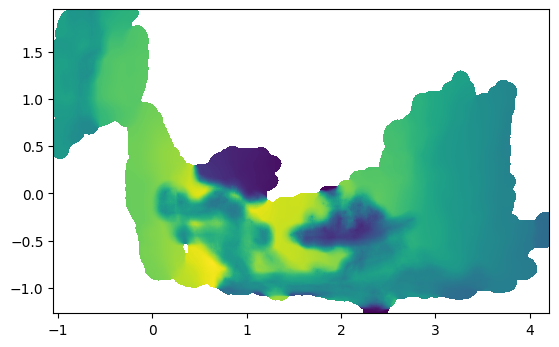

In [8]:
import pdal
import rasterio
from rasterio.plot import show
import json

# Define input and output file paths
input_file = '/content/20220714_132152.obj/20220714_132152.obj'
output_file = '/content/output.tif'

# Define PDAL pipeline for conversion
pipeline = [
    {
        'type': 'readers.obj',
        'filename': input_file
    },
    {
        'type': 'writers.gdal',
        'filename': output_file,
        'resolution': 0.001,
        'output_type': 'idw',
        'radius': 0.1,
        'dimension': 'Z'
    }
]

# Run PDAL pipeline
pipeline = pdal.Pipeline(json.dumps(pipeline))
pipeline.execute()

# Load output raster with Rasterio
with rasterio.open(output_file) as src:
    # Plot the raster
    show(src)


Now that we can get a lat/lng to figure out where we want to fetch some data, we need to buffer that out using [Web Mercator(https://en.wikipedia.org/wiki/Web_Mercator_projection) coordinate system, which is what the USGS 3DEP EPT data are stored in.

The following function does that for us by taking in the point, reprojecting it to EPSG:3857, buffering it out by a given amount, and returning that geometry back to the caller to use as it needs.

In [ ]:
def get_extent(lat, lng, buffer):
    """Compute a buffered geometry for a latitude and longitude"""

    from shapely.geometry import shape, Polygon
    from shapely.ops import transform
    import pyproj

    point = {"type": "Point", "coordinates": [lng, lat]}
    point = shape(point)

    webmercator = pyproj.CRS("EPSG:3857")
    wgs84 = pyproj.CRS("EPSG:4326")

    forward = pyproj.Transformer.from_crs(wgs84, webmercator, always_xy=True).transform
    reverse = pyproj.Transformer.from_crs(webmercator, wgs84, always_xy=True).transform

    p = transform(forward, point)
    poly_wm = Polygon([(p.x - buffer, p.y - buffer), (p.x + buffer, p.y - buffer),
              (p.x + buffer, p.y + buffer), (p.x - buffer, p.y + buffer)])

    poly_dd = transform(reverse, poly_wm)
    d = {}
    d['poly_dd'] = poly_dd
    d['poly_wm'] = poly_wm
    return d

Let's buffer our address by 500m and use GeoPandas to display it on the map to confirm we are in the right location.

In [ ]:
buffer = 500 #@param {type:"number"}
try:
    lat, lng = get_address(address)
except TypeError:
    print(f"Unable to fetch coordinates for address '{address}'")
    
extent = get_extent(lat, lng, 500)

d = {'address': [address], 'geometry': [extent['poly_dd']]}

boxes = geopandas.GeoDataFrame(d, crs='EPSG:4326')
boxes.explore()


# Figure out which EPT resource to use

Now that we have a reasonable location, we need to find out if there is data located over our area of interest.

One way to quickly confirm is to visit [usgs.entwine.io](https://usgs.entwine.io) and interact with the map, but we can also use GeoPandas to compute it and show us.

In [ ]:
pt = extent['poly_dd'].centroid

RESOURCES_URL = 'https://raw.githubusercontent.com/hobuinc/usgs-lidar/master/boundaries/resources.geojson'
urls = geopandas.read_file(RESOURCES_URL)

map = urls.explore()
bounds = extent['poly_dd'].bounds

# Jupyter's folium mapping module needs bounds in its
# own arrangement, so we are flipping them here
flipped_bounds = [[bounds[1], bounds[0]], [bounds[3], bounds[2]]]
map.fit_bounds(flipped_bounds)
map


# Compute the intersection 

We're going to let GeoPandas compute the intersection between the GeoJSON containing the 3DEP LiDAR footprints and our box.

In [ ]:
# execute a spatial join between the boxes pandas frame
# we made and the GeoJSON with the URLs
mixed = boxes.sjoin(urls, how='left', op='intersects')
url = mixed.url[0]
count = mixed['count'][0]

print (f'URL {url} has {count:,} points')

URL https://s3-us-west-2.amazonaws.com/usgs-lidar-public/USGS_LPC_MD_VA_Sandy_NCR_2014_LAS_2015/ept.json has 30,528,107,343 points


# Estimate how many points inside our area of interest

PDAL can give us an estimate of how many points will be inside the bounding geometry we give it, and this gives us an opportunity to explore the PDAL 
`readers.ept` stage. You can find more documentation about the stage at 
https://pdal.io/en/stable/stages/readers.ept.html



In [ ]:
# Because our data source is in Web Mercator, we can also 
# pass in a filter geometry to readers.ept in that coordinate system
# This will limit the queries against the data source to only points that 
# are within that polygon

reader = pdal.Reader.ept(url, polygon = extent['poly_wm'].wkt)
pipeline = reader.pipeline()

# The quickinfo call of a pipeline returns preview information about 
# a query without doing the work of returning all of the points and 
# processing it through the pipeline. This is especially useful in 
# scenarios such as EPT or COPC where we are reading over the network.
# We could use this check to prevent us from downloading too much 
# data or to hint our program to split the data into smaller work units 
# for a given query
qi = pipeline.quickinfo
count = qi['readers.ept']['num_points']
print (f'--------------------------\n{pipeline.pipeline}\n--------------------------\n')
print (f'Point count estimate {count:,}')

--------------------------
{
  "pipeline":
  [
    {
      "filename": "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/USGS_LPC_MD_VA_Sandy_NCR_2014_LAS_2015/ept.json",
      "polygon": "POLYGON ((-8575502.403026134 4706257.646428282, -8574502.403026134 4706257.646428282, -8574502.403026134 4707257.646428282, -8575502.403026134 4707257.646428282, -8575502.403026134 4706257.646428282))",
      "tag": "readers_ept1",
      "type": "readers.ept"
    },
    {
      "inputs":
      [
        "readers_ept1"
      ],
      "tag": "filters_merge1",
      "type": "filters.merge"
    }
  ]
}

--------------------------

Point count estimate 6,789,238


readers.ept is also sensitive to resolution in addition to using a bounding polygon or geometry. The ``resolution`` option tells the reader to query points that meet or exceed the given resolution estimate. In the example below, we are trying for 10m resolution, but depending on how the EPT tree structure was constructed, this might be 8m or 7m. The goal is to give you enough points to provide the needed density.

In [ ]:
resolution=10
reader = pdal.Reader.ept(url, 
                         resolution=resolution, 
                         polygon = extent['poly_wm'].wkt)
qi = reader.pipeline().quickinfo
count = qi['readers.ept']['num_points']
print (f'Point count estimate for resolution {resolution:.3f}: {count:,}')

Point count estimate for resolution 10.000: 792,223


# Make a Digital Surface Model

Now that we have our URL and know how to make a ``readers.ept``, we can use these together to produce our first lidar raster product, the digital surface model. Our definition of a DSM means that we are going to include all of the points except noise into our output product. The examples below will show how to use PDAL to filter out more points to produce the HeightAboveGround and Digitial Terrain Model products.

In [ ]:
resolution=0.5

useful_classes = "Classification[0:6],Classification[17:17],Classification[9:9],Classification[10:10],Classification[11:11]"

reader = pdal.Reader.ept(url, 
                         resolution=resolution, 
                         polygon = extent['poly_wm'].wkt)
rng = pdal.Filter.range(limits=useful_classes)
z = pdal.Writer.gdal("dsm.tif", 
                     resolution=resolution*2, 
                     dimension="Z", 
                     data_type="float32", 
                     output_type="mean",
                     nodata=0)

pipeline = reader | rng | z

pipeline.execute()


3528428

We will use simple GDAL commands to show the hillshade as a PNG


In [ ]:
%%bash
rm dsm.png; gdaldem hillshade dsm.tif dsm.png

0...10...20...30...40...50...60...70...80...90...100 - done.


rm: cannot remove 'dsm.png': No such file or directory


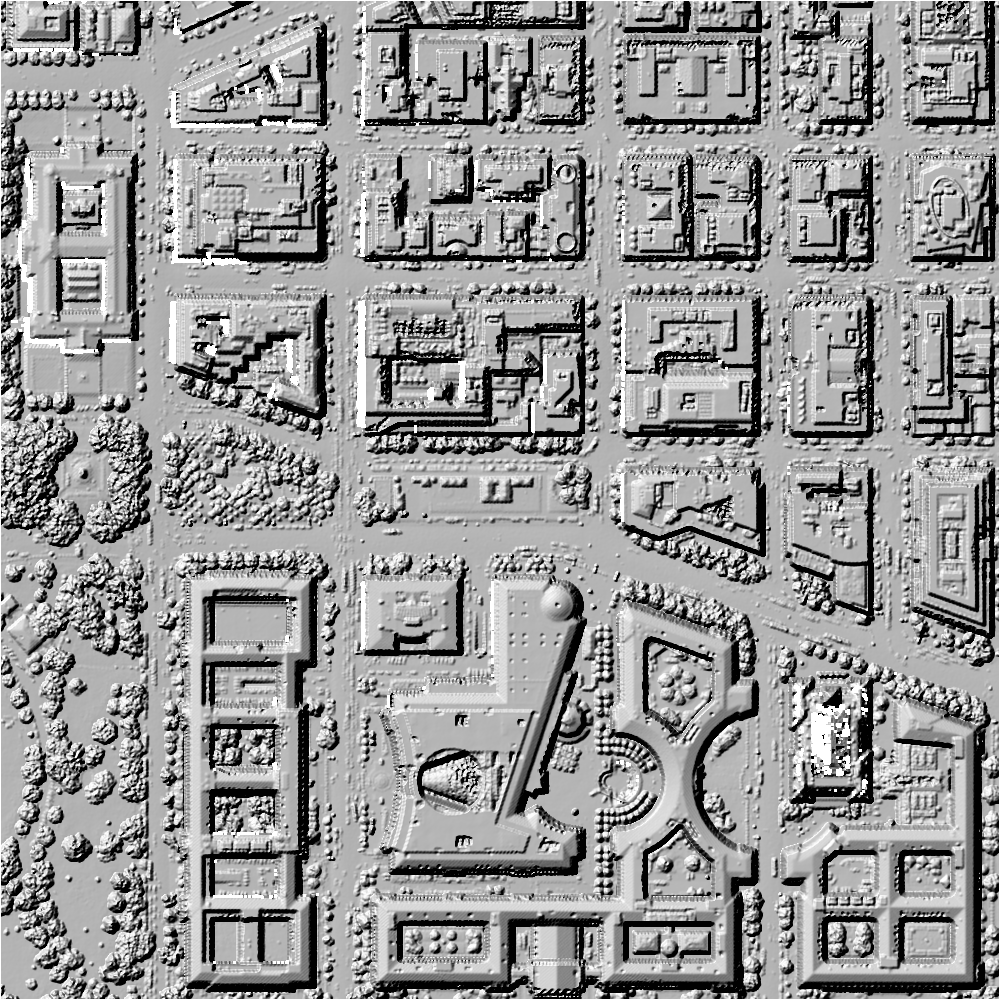

In [ ]:
from IPython.display import Image
Image(filename='dsm.png') 



It is also useful to see the histogram to make sure it makes sense for the data we have processed





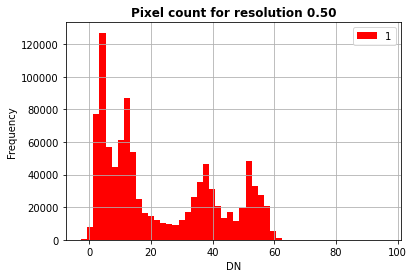

In [ ]:
import rasterio

dsm = rasterio.open("dsm.tif")
from rasterio.plot import show_hist

show_hist(dsm, bins=50,histtype='stepfilled',stacked=False, title=f"Pixel count for resolution {resolution:.2f}")

# Make a Digital Terrain Model

Now that we've made the DSM, the DTM is very similar except we are going to filter out more data from the point cloud as we process it into a raster.

In [ ]:
ground_classes = "Classification[2:2]"

reader = pdal.Reader.ept(url, 
                         resolution=resolution, 
                         polygon = extent['poly_wm'].wkt)
rng = pdal.Filter.range(limits=ground_classes)
z = pdal.Writer.gdal("dtm.tif", 
                     resolution=resolution*2, 
                     dimension="Z", 
                     data_type="float32", 
                     output_type="mean",
                     nodata=0)

dtm_pipeline = reader | rng | z

dtm_pipeline.execute()


610097

In [ ]:
%%bash
rm dtm.png; gdaldem hillshade dtm.tif dtm.png

0...10...20...30...40...50...60...70...80...90...100 - done.


rm: cannot remove 'dtm.png': No such file or directory


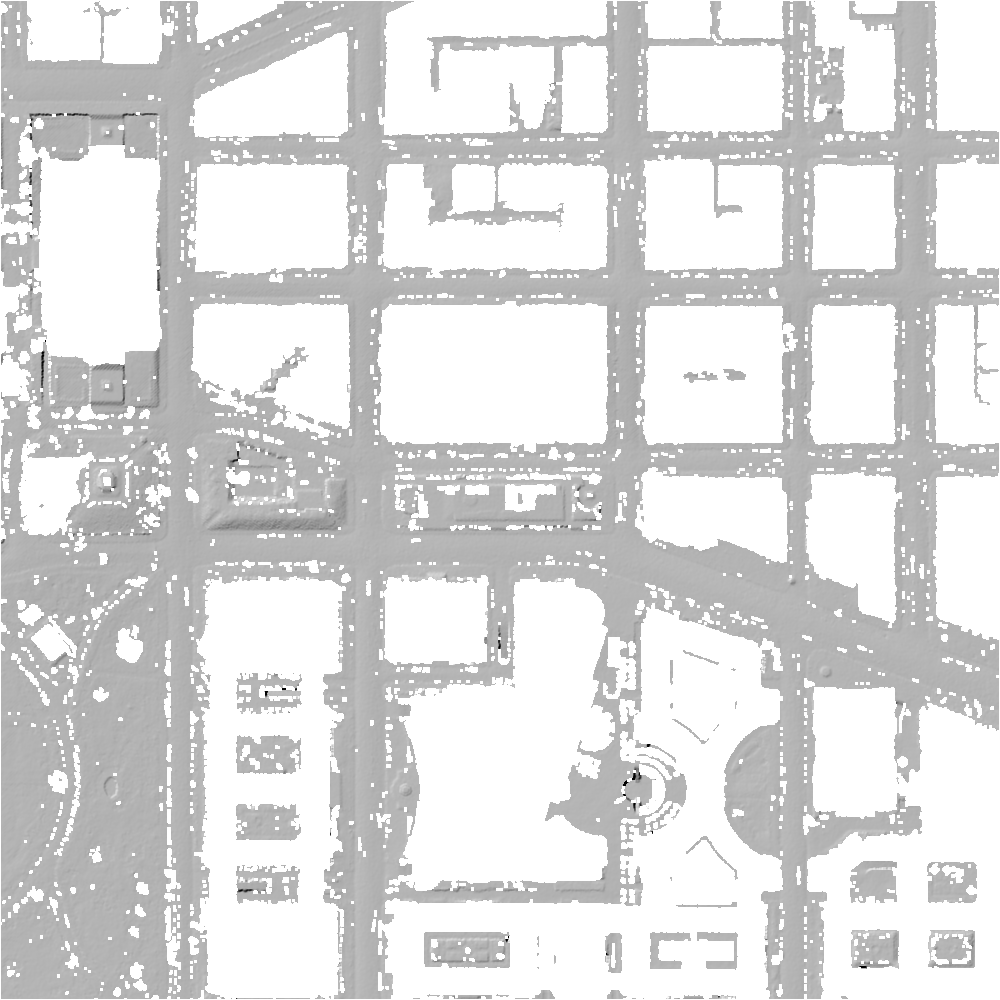

In [ ]:
from IPython.display import Image
Image(filename='dtm.png') 

# Making an Intensity preview image

An image of the Intensity data is a useful backdrop for data validation and context. One of the problems with 3DEP LiDAR data is Intensity is often not normalized. Sometimes it is between 0-256, and other times it is between 0-65536.

We can use PDAL to normalize the Intensity values by using [filters.assign](https://pdal.io/en/stable/stages/filters.assign.html) to divide the data by 256 if the range of data is greater than 256 (which tells us the data are 16bit instead of 8bit data).

In [ ]:
# After you execute a pipeline, the point data is available in the .arrays 
# data property as a Numpy Structured Arrays https://numpy.org/doc/stable/user/basics.rec.html
# We are going to use the data from the past execution to tell us 
# whether or not we should rescale the intensity data.

intensity = dtm_pipeline.arrays[0]['Intensity']
print (np.min(intensity), np.max(intensity))

is16Bit = False
if np.max(intensity) > 255:
  is16Bit = True

assign = pdal.Filter.assign(value = [
          "Intensity = Intensity / 256"
      ])

reader = pdal.Reader.ept(url, 
                         resolution=resolution, 
                         polygon = extent['poly_wm'].wkt)
rng = pdal.Filter.range(limits=useful_classes)
z = pdal.Writer.gdal("intensity.tif", 
                     resolution=resolution*2, 
                     dimension="Intensity", 
                     data_type="uint8", 
                     output_type="mean",
                     nodata=0)

# The |= operator of PDAL Pipeline objects allows you 
# to compose them and stack them together.
pipeline = reader 
if is16Bit:
  pipeline |= assign

pipeline |= rng | z

pipeline.execute()


0 255


3484342

In [ ]:
%%bash
rm intensity.png; gdal_translate intensity.tif intensity.png

Input file size is 1000, 1000
0...10...20...30...40...50...60...70...80...90...100 - done.


rm: cannot remove 'intensity.png': No such file or directory


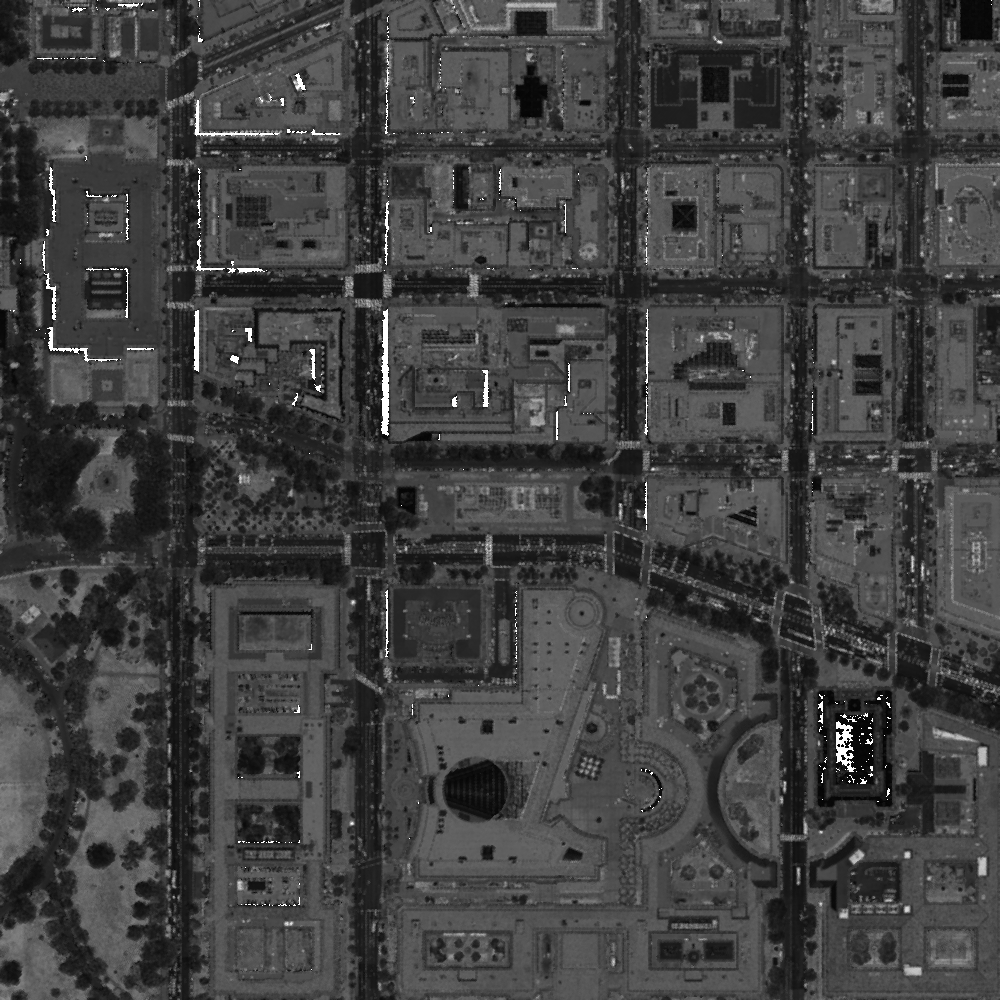

In [ ]:
from IPython.display import Image
Image(filename='intensity.png') 

# Making a CHM

Computing the Canopy Height Model, or HeightAboveGround, with PDAL is straightforward by applying another filter. There are two to choose from for CHM construction – [filters.hag_nn ](https://pdal.io/en/stable/stages/filters.hag_nn.html)or [filters.hag_delaunay](https://pdal.io/en/stable/stages/filters.hag_delaunay.html). For our purposes, the hag_nn should be sufficient, but there is a lot of options and configuration that you can adjust to control your output.

In [ ]:
intensity = dtm_pipeline.arrays[0]['Intensity']
print (np.min(intensity), np.max(intensity))

is16Bit = False
if np.max(intensity) > 255:
  is16Bit = True

assign = pdal.Filter.assign(value = [
          "Intensity = Intensity / 256"
      ])

reader = pdal.Reader.ept(url, 
                         resolution=resolution, 
                         polygon = extent['poly_wm'].wkt)
rng = pdal.Filter.range(limits=useful_classes)
hag = pdal.Filter.hag_nn()
z = pdal.Writer.gdal("hag.tif", 
                     resolution=resolution*2, 
                     dimension="HeightAboveGround", 
                     data_type="float32", 
                     output_type="mean",
                     nodata=0)

pipeline = reader | rng | hag | z

pipeline.execute()

0 255


3484342

In [ ]:
colorramp="""-900,247,251,255,0,-0.0017
1,226,237,248,255,1.0000
1.5,205,224,241,255,1.5000
2.25,175,209,231,255,2.2500
3,137,190,220,255,3.0000
4,96,166,210,255,4.0000
4.5,62,142,196,255,4.5000
5.5,34,114,181,255,5.5000
6.25,10,84,158,255,6.2500
7,8,48,107,255,7.0000
"""
with open('hag-legend.txt','w') as f:
  f.write(colorramp)


In [ ]:
%%bash
rm hag.png; gdaldem color-relief hag.tif hag-legend.txt hag.png

0...10...20...30...40...50...60...70...80...90...100 - done.


rm: cannot remove 'hag.png': No such file or directory


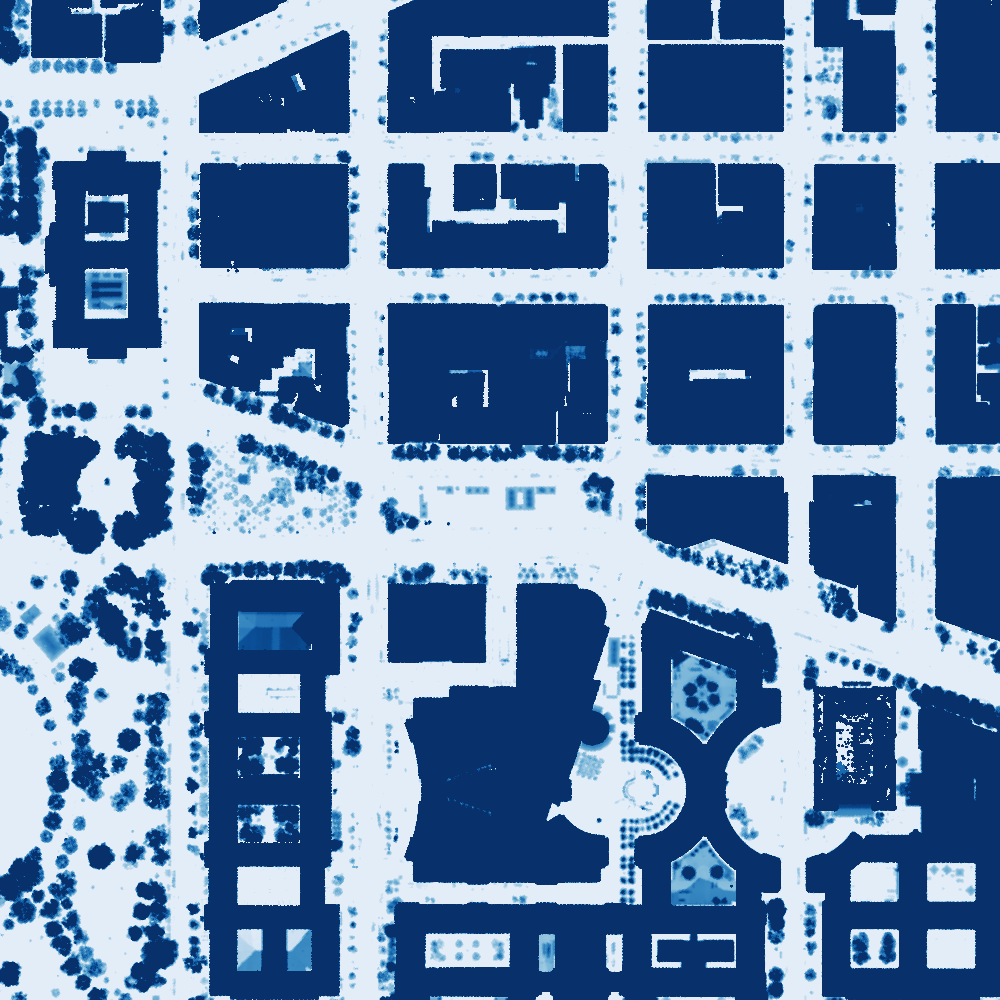

In [ ]:
from IPython.display import Image
Image(filename='hag.png') 